In [1]:
import sys

import matplotlib.pyplot as plt

%matplotlib notebook
%matplotlib notebook
## save variables
import pickle
## folder names
from glob import glob
## standard libraries
import numpy as np

##
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import normalize


#!{sys.executable} -m pip install tensorflow-gpu --user
#!{sys.executable} -m pip install keras --user
import tensorflow as tf
from keras import backend as k

import keras
from keras.optimizers import SGD
#!{sys.executable} -m pip install hyperas --user
#!{sys.executable} -m pip install networkx==1.11 --user

from hyperas import optim
from hyperas.distributions import choice, uniform, conditional
from hyperopt import Trials, STATUS_OK, tpe

import os.path
import datetime

from dependencies import models
from dependencies import functions

from dependencies.convnet_drawer.convnet_drawer import Model
from dependencies.convnet_drawer.convnet_drawer import Conv2D
from dependencies.convnet_drawer.convnet_drawer import MaxPooling2D as MaxPooling2D_drawer
from dependencies.convnet_drawer.convnet_drawer import Flatten as Flatten_drawer
from dependencies.convnet_drawer.convnet_drawer import Dense as Dense_drawer
from dependencies.convnet_drawer.matplotlib_util import save_model_to_file
from dependencies.convnet_drawer.keras_util import convert_drawer_model

C:\Users\yurin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Import mfcc data

In [2]:
#choose which dictionary to use
choice = 'mfcc'#'spectro'


selected = 0
if choice == 'mfcc':
    
    #retrieving of used values for the computation of mfcc
    with open('variables/mfccValues.pkl', 'rb') as f:  
        values = pickle.load(f)
    
    #name format of the selected data
    name = 'variables/mfccDict[nC='+str(values[selected][0])+' wL='+str(values[selected][2])+' wS='+str(values[selected][3])+'].pkl'
    
    #saving in usedDict of the mfcc dict
    with open(name, 'rb') as f: 
        usedDict = pickle.load(f)
    print('Loaded '+name)

elif choice == 'spectro':
    
    #saving in usedDict of the spectro dict
    with open('variables/spectroDict.pkl', 'rb') as f:  
        usedDict = pickle.load(f)
    print('Loaded spectroram')

Loaded variables/mfccDict[nC=14 wL=0.025 wS=0.01].pkl


# Acquiring and scaling data

In [3]:
#core words of the dataset
coreKey = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "zero",
           "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

#split of the core set
numbers = ['one', 'two', 'three','four','five','six','seven','eight','nine', "zero"]
words = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

test = ["yes", "up", "down", "left"]#, "right", "on", "off", "stop", "go", "zero",
          # "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

#selecting the subset of words
used = words

used.append('silence')
unknown = list(usedDict.keys())
for key in used:
    try:
        unknown.remove(key)
    except:
        print(key, ' not in used')

#divding between train and test with also scaling data
x_train, y_train, x_test, y_test, labelList = functions.train_test_creator(
    {k: usedDict[k] for k in usedDict.keys() & used },
    {k: usedDict[k] for k in usedDict.keys() & unknown },
    with_unknown = True,
    scalerType = 'robust')


# Fitting

In [4]:
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.7
 
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [5]:
cnn = models.model1(x_train,y_train)
print("Model1")
cnn.summary()

cnn = models.model2(x_train,y_train)
print("Model2")
cnn.summary()

cnn = models.model3(x_train,y_train)
print("Model3")
cnn.summary()

cnn = models.tinyDarknet(x_train,y_train)
print("tiny darknet")
cnn.summary()

Model1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 93, 11, 64)        1856      
_________________________________________________________________
batch_normalization_1 (Batch (None, 93, 11, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 5, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 5, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 4, 128)        65664     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 4, 128)        512       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 2, 256)        393472    
___

tiny darknet
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 99, 14, 32)        320       
_________________________________________________________________
batch_normalization_14 (Batc (None, 99, 14, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 99, 14, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 99, 14, 16)        528       
_________________________________________________________________
batch_normalization_15 (Batc (None, 99, 14, 16)        64        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 99, 14, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 99, 14, 64)        9280    

In [9]:
epoch = 40
epochSGD = 20

dest_directory = 'model_backup/'
if not os.path.exists(dest_directory):
      os.makedirs(dest_directory)

tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)


MODEL1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 93, 11, 64)        1856      
_________________________________________________________________
batch_normalization_35 (Batc (None, 93, 11, 64)        256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 31, 5, 64)         0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 31, 5, 64)         0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 28, 4, 128)        65664     
_________________________________________________________________
batch_normalization_36 (Batc (None, 28, 4, 128)        512       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 25, 2, 256)        393472    
___

40451/40451 [==============================] - 9s 218us/step - loss: 0.2536 - acc: 0.9201 - val_loss: 0.4015 - val_acc: 0.9162
Epoch 3/20
40451/40451 [==============================] - 9s 217us/step - loss: 0.2432 - acc: 0.9227 - val_loss: 0.3698 - val_acc: 0.9211
Epoch 4/20
40451/40451 [==============================] - 9s 219us/step - loss: 0.2410 - acc: 0.9243 - val_loss: 0.3890 - val_acc: 0.9204
Epoch 5/20
40451/40451 [==============================] - 9s 218us/step - loss: 0.2334 - acc: 0.9260 - val_loss: 0.3970 - val_acc: 0.9195
Epoch 6/20
40451/40451 [==============================] - 9s 217us/step - loss: 0.2353 - acc: 0.9261 - val_loss: 0.4079 - val_acc: 0.9197
Epoch 7/20
40451/40451 [==============================] - 9s 216us/step - loss: 0.2335 - acc: 0.9264 - val_loss: 0.4121 - val_acc: 0.9197
Epoch 8/20
40451/40451 [==============================] - 9s 217us/step - loss: 0.2315 - acc: 0.9272 - val_loss: 0.3829 - val_acc: 0.9208
Epoch 9/20
40451/40451 [=====================

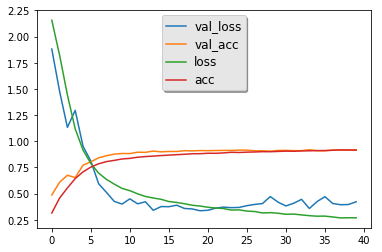

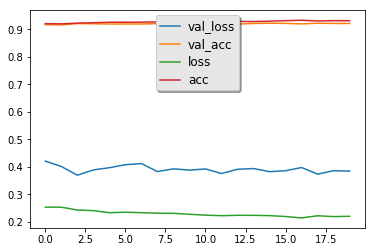

Wall time: 9min 4s


In [14]:
%%time

print("MODEL1")
cnn = models.model1(x_train,y_train)

cnn.summary()


compiledAdam = cnn.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
fittedAdam = cnn.fit(x_train, y_train,
                     epochs=epoch,
                     validation_data=(x_test, y_test),
                     batch_size=round(x_train.shape[0]/100),
                     shuffle=True,
                     callbacks = [tbCallBack])

sgd = SGD(lr=0.01, decay=0.0005, momentum=0.9, nesterov=True)
compiledSGD = cnn.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

fittedSGD = cnn.fit(x_train, y_train, 
                epochs=epochSGD, 
                validation_data=(x_test, y_test), 
                batch_size=round(x_train.shape[0]/100), 
                shuffle=True,
                callbacks = [tbCallBack])

fig, ax = plt.subplots()
x = range(epoch)
for key in fittedAdam.history:
    ax.plot(x,fittedAdam.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

fig, ax = plt.subplots()
x = range(epochSGD)
for key in fittedSGD.history:
    ax.plot(x,fittedSGD.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width


plt.show()

name = 'cnn1.bak'
cnn.save(dest_directory + name)


MODEL3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 96, 13, 16)        144       
_________________________________________________________________
activation_5 (Activation)    (None, 96, 13, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 96, 13, 32)        2080      
_________________________________________________________________
activation_6 (Activation)    (None, 96, 13, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 96, 13, 64)        8256      
_________________________________________________________________
activation_7 (Activation)    (None, 96, 13, 64)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 96, 13, 64)        256       
__

40451/40451 [==============================] - 9s 233us/step - loss: 0.4907 - acc: 0.8428 - val_loss: 0.5100 - val_acc: 0.8380
Epoch 32/40
40451/40451 [==============================] - 10s 238us/step - loss: 0.4872 - acc: 0.8436 - val_loss: 0.7102 - val_acc: 0.8148
Epoch 33/40
40451/40451 [==============================] - 10s 237us/step - loss: 0.4763 - acc: 0.8460 - val_loss: 0.3659 - val_acc: 0.8796
Epoch 34/40
40451/40451 [==============================] - 9s 233us/step - loss: 0.4762 - acc: 0.8465 - val_loss: 0.4378 - val_acc: 0.8721
Epoch 35/40
40451/40451 [==============================] - 9s 234us/step - loss: 0.4712 - acc: 0.8495 - val_loss: 0.6099 - val_acc: 0.8084
Epoch 36/40
40451/40451 [==============================] - 9s 234us/step - loss: 0.4703 - acc: 0.8495 - val_loss: 0.6704 - val_acc: 0.8235
Epoch 37/40
40451/40451 [==============================] - 9s 234us/step - loss: 0.4585 - acc: 0.8538 - val_loss: 0.4664 - val_acc: 0.8558
Epoch 38/40
40451/40451 [============

ValueError: x and y must have same first dimension, but have shapes (40,) and (20,)

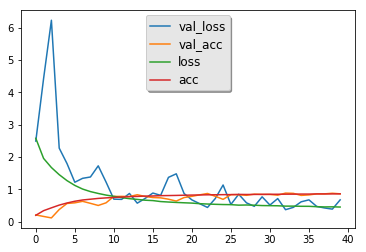

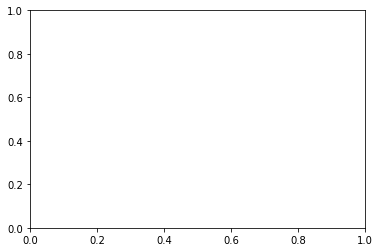

In [11]:
%%time
print("\nMODEL3")
cnn = models.model3(x_train,y_train)

cnn.summary()


compiledAdam = cnn.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
fittedAdam = cnn.fit(x_train, y_train,
                     epochs=epoch,
                     validation_data=(x_test, y_test),
                     batch_size=round(x_train.shape[0]/100),
                     shuffle=True,
                     callbacks = [tbCallBack])

sgd = SGD(lr=0.01, decay=0.0005, momentum=0.9, nesterov=True)
compiledSGD = cnn.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

fittedSGD = cnn.fit(x_train, y_train, 
                epochs=epochSGD, 
                validation_data=(x_test, y_test), 
                batch_size=round(x_train.shape[0]/100), 
                shuffle=True,
                callbacks = [tbCallBack])

fig, ax = plt.subplots()
x = range(epoch)
for key in fittedAdam.history:
    ax.plot(x,fittedAdam.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

fig, ax = plt.subplots()
x = range(epochSGD)
for key in fittedSGD.history:
    ax.plot(x,fittedSGD.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
    
plt.show()

name = 'cnn3.bak'
cnn.save(dest_directory + name)


TINYDARKNET
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 99, 14, 32)        320       
_________________________________________________________________
batch_normalization_18 (Batc (None, 99, 14, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 99, 14, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 99, 14, 16)        528       
_________________________________________________________________
batch_normalization_19 (Batc (None, 99, 14, 16)        64        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 99, 14, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 99, 14, 64)        9280    

Epoch 3/40
40451/40451 [==============================] - 27s 669us/step - loss: 0.7689 - acc: 0.7595 - val_loss: 0.4708 - val_acc: 0.8546
Epoch 4/40
40451/40451 [==============================] - 27s 669us/step - loss: 0.5681 - acc: 0.8259 - val_loss: 0.3629 - val_acc: 0.8884
Epoch 5/40
40451/40451 [==============================] - 27s 669us/step - loss: 0.4710 - acc: 0.8582 - val_loss: 0.3093 - val_acc: 0.9047
Epoch 6/40
40451/40451 [==============================] - 27s 671us/step - loss: 0.3896 - acc: 0.8840 - val_loss: 0.2995 - val_acc: 0.9015
Epoch 7/40
40451/40451 [==============================] - 27s 671us/step - loss: 0.3476 - acc: 0.8959 - val_loss: 0.2848 - val_acc: 0.9088
Epoch 8/40
40451/40451 [==============================] - 27s 671us/step - loss: 0.3018 - acc: 0.9095 - val_loss: 0.2767 - val_acc: 0.9091
Epoch 9/40
40451/40451 [==============================] - 27s 671us/step - loss: 0.2770 - acc: 0.9164 - val_loss: 0.2528 - val_acc: 0.9198
Epoch 10/40
40451/40451 [==

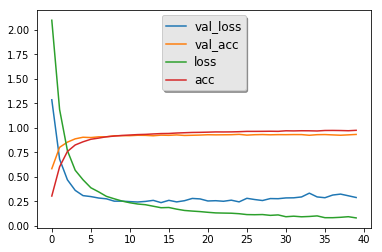

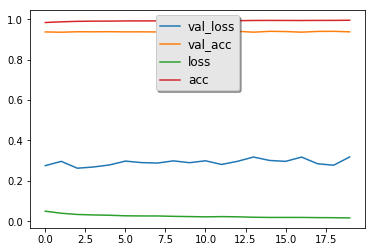

Wall time: 27min 5s


In [13]:
%%time
print("\nTINYDARKNET")
cnn = models.tinyDarknet(x_train,y_train)
cnn.summary()


compiledAdam = cnn.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
fittedAdam = cnn.fit(x_train, y_train,
                     epochs=epoch,
                     validation_data=(x_test, y_test),
                     batch_size=round(x_train.shape[0]/150),
                     shuffle=True,
                     callbacks = [tbCallBack])

sgd = SGD(lr=0.01, decay=0.0005, momentum=0.9, nesterov=True)
compiledSGD = cnn.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

fittedSGD = cnn.fit(x_train, y_train, 
                epochs=epochSGD, 
                validation_data=(x_test, y_test), 
                batch_size=round(x_train.shape[0]/150), 
                shuffle=True,
                callbacks = [tbCallBack])

fig, ax = plt.subplots()
x = range(epoch)
for key in fittedAdam.history:
    ax.plot(x,fittedAdam.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

fig, ax = plt.subplots()
x = range(epochSGD)
for key in fittedSGD.history:
    ax.plot(x,fittedSGD.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
    
plt.show()

name = 'cnn4.bak'
cnn.save(dest_directory + name)

In [ ]:
#!tensorboard --logdir Graph/

# Score

In [ ]:
#find prediction with test data
preds = cnn.predict(x_test)
print(list(used))

#plot confusion matrix
functions.plotConfusionMatrix(preds,y_test,list(used))
loss, precision = cnn.evaluate(x_test,y_test)
print ("Precision: ", round(precision*100,2),"%")

In [ ]:
fig, ax = plt.subplots()
x = range(epoch)
for key in fittedAdam.history:
    ax.plot(x,fittedAdam.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

plt.show()
    

# Output of conv2D

In [ ]:
cnn_copy = Sequential()
cnn_copy.add(cnn.layers[0])
result = cnn_copy.predict(x_test)


In [ ]:
plt.figure()
plt.imshow(result[0,:,:,0])

# Save Model

In [ ]:
dest_directory = 'model_backup/'
if not os.path.exists(dest_directory):
      os.makedirs(dest_directory)
name = 'cnn.bak'
cnn.save(dest_directory + name)

#bak = load_model(dest_directory + name)


In [ ]:
model = Model(input_shape=(x_train.shape[1], x_train.shape[2],1))
model.add(Conv2D(100, (4,4),  strides = (1,1), padding="valid"))
model.add(Conv2D(100, (4,2),  strides = (1,1), padding="valid"))
model.add(MaxPooling2D_drawer(pool_size=(3,3)))
model.add(Conv2D(128, (4,2),  strides = (1,1), padding="valid"))
model.add(Conv2D(128, (5,2),  strides = (1,1), padding="valid"))
model.add(MaxPooling2D_drawer(pool_size=(4,1)))
model.add(Flatten_drawer())
model.add(Dense_drawer(100))
model.add(Dense_drawer(y_train.shape[1]))

#save to pdf
save_model_to_file(model, "example.pdf")

# Looking for hyperparameters

In [ ]:
from keras.activations import softmax
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten, Dropout, Convolution2D, MaxPooling2D, AveragePooling2D, BatchNormalization
trials = Trials()
best_run, best_model = optim.minimize(model=functions.create_model, 
                                      data=functions.data,
                                      algo=tpe.suggest,
                                      max_evals=100,
                                      trials=trials,
                                      notebook_name='Processing')

In [ ]:
dest_directory = 'model_backup/'
'''
best_model = load_model(dest_directory + 'best_model.bak')

with open(dest_directory+'best_run.pkl', 'rb') as f:  
    best_run = pickle.load(f)    
'''
print("Evalutation of best performing model:")
print(best_model.evaluate(x_test, y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)
best_model.summary()




now = datetime.datetime.now()
dest_directory_temp =dest_directory + 'bestModel('+now.strftime("%m-%d %H.%M")+")"
if not os.path.exists(dest_directory_temp):
      os.makedirs(dest_directory_temp)
best_model.save(dest_directory_temp + '/best_model.bak')

with open(dest_directory_temp + '/best_run.pkl', 'wb') as f:  
    pickle.dump(best_run, f)



In [ ]:
trials.best_trial